<ipython-input-1-ee5ed3eb037e>:20: RuntimeWarning: overflow encountered in add
  interest_rates[t + 1, :] = interest_rates[t, :] + drift + diffusion
C:\Users\spark\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
<ipython-input-1-ee5ed3eb037e>:20: RuntimeWarning: overflow encountered in add
  interest_rates[t + 1, :] = interest_rates[t, :] + drift + diffusion


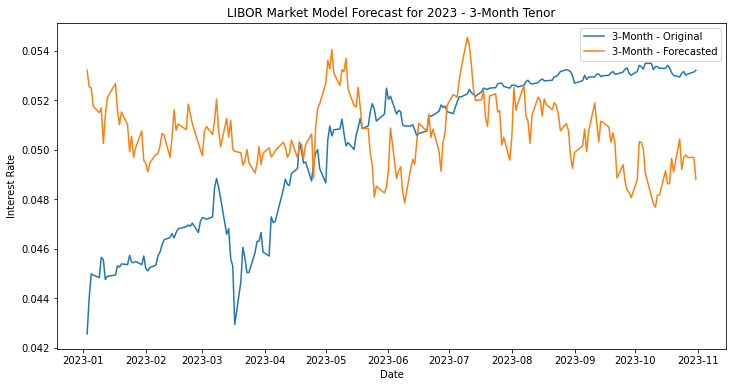

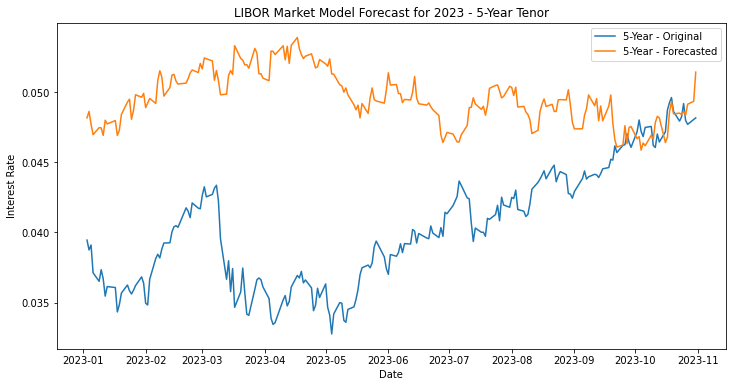

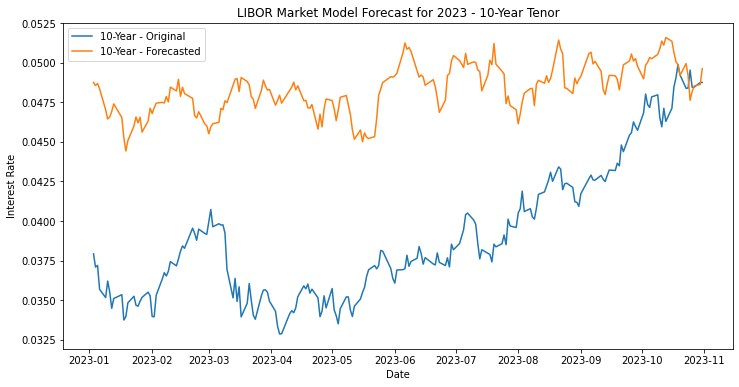

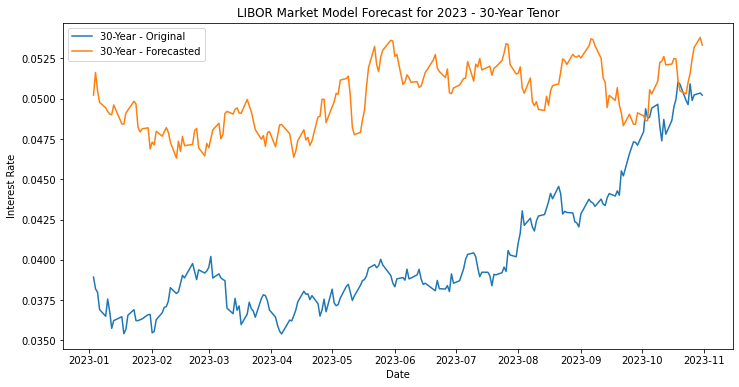

Original 2023 Data (LIBOR Market Model):
            3-Month   5-Year  10-Year  30-Year
Date                                          
2023-01-03  0.04255  0.03945  0.03793  0.03893
2023-01-04  0.04400  0.03875  0.03709  0.03820
2023-01-05  0.04498  0.03910  0.03720  0.03798
2023-01-06  0.04493  0.03712  0.03569  0.03692
2023-01-09  0.04483  0.03651  0.03517  0.03650
...             ...      ...      ...      ...
2023-10-25  0.05315  0.04918  0.04953  0.05092
2023-10-26  0.05300  0.04797  0.04845  0.04988
2023-10-27  0.05305  0.04770  0.04845  0.05023
2023-10-30  0.05313  0.04804  0.04875  0.05035
2023-10-31  0.05320  0.04816  0.04875  0.05022

[209 rows x 4 columns]

Forecasted 2023 Data (LIBOR Market Model):
             3-Month    5-Year   10-Year   30-Year
Date                                              
2023-01-03  0.053200  0.048160  0.048750  0.050220
2023-01-04  0.052528  0.048618  0.048556  0.051626
2023-01-05  0.052494  0.047709  0.048682  0.050495
2023-01-06  0.051752  0.0

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Function to simulate LMM model
def libor_market_model(params, initial_rates, time_step, num_steps, num_paths):
    alpha, rho, sigma = params
    
    # Generate correlated Brownian motions
    dW = np.random.normal(0, np.sqrt(time_step), size=(num_steps, num_paths))
    
    # Initialize interest rates matrix
    interest_rates = np.zeros((num_steps + 1, num_paths))
    interest_rates[0, :] = initial_rates
    
    # Discretize the model using Euler method
    for t in range(num_steps):
        drift = alpha * (rho - interest_rates[t, :]) * time_step
        diffusion = sigma * np.sqrt(time_step) * dW[t, :]
        interest_rates[t + 1, :] = interest_rates[t, :] + drift + diffusion
    
    return interest_rates

# Calibration function for LMM model
def libor_calibration(params, data, time_step, num_steps):
    initial_rate = data.iloc[0]
    simulated_rates = libor_market_model(params, initial_rate, time_step, num_steps, num_paths=1)
    return np.sum((simulated_rates[-1, :] - data) ** 2)

# Load combined data (Interest rate data)
combined_interest_data = pd.read_csv('interest_rate_data.csv', index_col='Date', parse_dates=True)/100

# Set time step for simulation
time_step_lmm = 1

# Define calibration and forecasting periods
calibration_end_date = '2022-12-31'
forecasting_start_date = '2023-01-01'

# Extract data for calibration and forecasting
calibration_data = combined_interest_data.loc[:calibration_end_date]
forecasting_data = combined_interest_data.loc[forecasting_start_date:]

# Set number of steps for calibration
num_steps_calibration = len(calibration_data) - 1 #as we are using 2000 to 2022 for calibration

# Initial guess for parameters
initial_guess_lmm = [0.05, 0.05, 0.05]  # Alpha, rho, sigma

# Set a seed for reproducibility
seed = 50  # We can choose any integer

# Calibrate using historical data from 2000 to 2022 for each tenor
calibrated_params_lmm = {
    tenor: minimize(libor_calibration, initial_guess_lmm, args=(combined_interest_data[tenor].loc[:calibration_end_date], time_step_lmm, num_steps_calibration)).x
    for tenor in combined_interest_data.columns
}

# Monte Carlo simulation for 2023
num_paths_lmm = 5000
simulation_results_lmm = {
    tenor: libor_market_model(params, combined_interest_data[tenor].iloc[-1], time_step_lmm, len(forecasting_data)-1, num_paths_lmm)
    for tenor, params in calibrated_params_lmm.items()
}

# Create DataFrame with original 2023 data and forecasted data
original_data_lmm = forecasting_data
forecasted_data_lmm = pd.DataFrame({tenor: np.mean(paths, axis=1) for tenor, paths in simulation_results_lmm.items()}, index=forecasting_data.index)

# Calculate the difference between original and forecasted data
difference_data_lmm = original_data_lmm - forecasted_data_lmm

# Calculate the standard deviation of differences
std_dev_difference = difference_data_lmm.std()

# Calculate the root mean squared error (RMSE)
rmse_per_tenor = np.sqrt(np.mean(difference_data_lmm**2,axis=0))

# Visualize the results for each tenor
for tenor in combined_interest_data.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(original_data_lmm.index, original_data_lmm[tenor], label=f"{tenor} - Original")
    plt.plot(original_data_lmm.index, forecasted_data_lmm[tenor], label=f"{tenor} - Forecasted")
    plt.title(f"LIBOR Market Model Forecast for 2023 - {tenor} Tenor")
    plt.xlabel("Date")
    plt.ylabel("Interest Rate")
    plt.legend()
    plt.show()

# Display the DataFrames for LIBOR Market Model
print("Original 2023 Data (LIBOR Market Model):")
print(original_data_lmm)
print("\nForecasted 2023 Data (LIBOR Market Model):")
print(forecasted_data_lmm)
print("\nDifference between Original and Forecasted Data (LIBOR Market Model):")
print(difference_data_lmm)
print("\nMean Difference between Original and Forecasted Data (LIBOR Market Model):")
print(difference_data_lmm.mean())
print("Calibrated Parameters (LIBOR Market Model):")
print("Standard Deviation of Differences:")
print(std_dev_difference)
print("Root Mean Squared Error (RMSE) for Each Tenor:")
print(rmse_per_tenor)
print(calibrated_params_lmm)
